In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
import string
from nltk.corpus import stopwords
PUNCT_TO_REMOVE = string.punctuation
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L2, L1L2
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.layers import Dense, GRU, LSTM, Bidirectional, Input, Dropout, GlobalAveragePooling1D, LayerNormalization, BatchNormalization, Conv1D
from tensorflow.keras.callbacks import EarlyStopping
from transformers import BertTokenizer , TFBertModel
AUTO = tf.data.experimental.AUTOTUNE

/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/config.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/tokenizer.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/tf_model.h5
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/tokenizer_config.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/pytorch_model.bin
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/vocab.txt
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/flax_model.msgpack
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/whole-word-masking/._bert_config.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/whole-word-masking/bert_config.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/whole-word-masking/pytorch_model.bin
/

2022-12-10 17:49:44.740030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-10 17:49:44.741607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-10 17:49:44.742700: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-10 17:49:44.745213: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [2]:
train_df = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/train.csv')
test_df = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')
sample_df = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv')
bert_path = '../input/huggingface-bert-variants/bert-base-uncased/bert-base-uncased'
print(train_df.shape, test_df.shape, sample_df.shape)

(3911, 8) (3, 2) (3, 7)


In [3]:
size = train_df.shape[0]
train, validate = int(0.8*size), int(0.2*size)
validate_df = train_df.tail(validate).copy()
train_df = train_df.head(train).copy()
print(train_df.shape, validate_df.shape)

(3128, 8) (782, 8)


In [4]:
# Merging Train and Test Data
train_size = train_df.shape[0]
test_size = test_df.shape[0]
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['text_id'], axis=1, inplace=True)
validate_df.drop(['text_id'], axis=1, inplace=True)
print(all_data.shape, validate_df.shape)

(3131, 7) (782, 7)


In [15]:
lemmatizer = WordNetLemmatizer()

def preprocess(text) : 
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+','', text)
    text = re.sub(r'@[0-9a-zA-Z]*\W+',' ' , text)
    
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\#', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    list_text = text.split()
    text = ' '.join(list_text[:512])
    return text

In [16]:
all_data['full_text'] = all_data['full_text'].apply(lambda text : preprocess(text))
validate_df['full_text'] = validate_df['full_text'].apply(lambda text : preprocess(text))

In [17]:
train_data = all_data[:train_size].copy()
test_data = all_data[train_size:].copy()

print(train_data.shape, test_data.shape)

(3128, 7) (3, 7)


In [18]:
## Tokenizer
tokenizer = BertTokenizer.from_pretrained(bert_path)

# Batch size and max sequence length
BATCH_SIZE = 5
MAX_LEN = max(len(x.split()) for x in all_data['full_text'])

def encode(input_text):
    inputs = tokenizer.batch_encode_plus(input_text,padding='max_length',max_length=MAX_LEN, truncation=True)
    return inputs

In [19]:
train_input = encode(train_data['full_text'].values.tolist())['input_ids']

train_data_ds = (
    tf.data.Dataset
    .from_tensor_slices((train_input,train_data.drop('full_text', axis = 1)))
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [20]:
testing_input = encode(test_data.full_text.values.tolist())['input_ids']

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(testing_input)
    .batch(BATCH_SIZE)
)

In [21]:
validate_input = encode(validate_df['full_text'].values.tolist())['input_ids']

validate_dataset = (
    tf.data.Dataset
    .from_tensor_slices((validate_input, validate_df.drop('full_text', axis = 1)))
    .batch(BATCH_SIZE)
)

In [22]:
## Column-wise RMSE
def MCRMSE(y_true, y_pred):
    mcrmse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(mcrmse), axis=-1, keepdims=True)

In [50]:
def create_model():
    
    ## Pretrained layer
    bert_encoder = TFBertModel.from_pretrained(bert_path)
    input_word_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")

    ## Embedding layer
    embedding = bert_encoder(input_word_ids)[0]
    x = GlobalAveragePooling1D()(embedding)
    x = LayerNormalization()(x)
    
    ## Compile model
    output1 = Dense(64, activation='relu')(x)
    output1 = Dense(1, name='cohesion')(output1)
    output2 = Dense(64, activation='relu')(x)
    output2 = Dense(1, name='syntax')(output2)
    output3 = Dense(64, activation='relu')(x)
    output3 = Dense(1, name='vocabulary')(output3)
    output4 = Dense(64, activation='relu')(x)
    output4 = Dense(1, name='phraseology')(output4)
    output5 = Dense(64, activation='relu')(x)
    output5 = Dense(1, name='grammar')(output5)
    output6 = Dense(64, activation='relu')(x)
    output6 = Dense(1, name='conventions')(output6)
    model = Model(inputs=input_word_ids, outputs=[output1, output2, output3, output4, output5, output6])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-6), loss=MCRMSE
                  , metrics=MCRMSE)
    
    ## LSTM
#     g = Bidirectional(LSTM(256, return_sequences=True))(embedding)
#     g = BatchNormalization()(g)

# v1
#     l = Bidirectional(LSTM(32, return_sequences=True))(embedding)
#     l = Dropout(0.4)(l)
#     l = Bidirectional(LSTM(16))(l)
    
# v2
#     l1 = Conv1D(filters=48, kernel_size=8, padding='valid', activation='relu')(embedding)
#     l1 = BatchNormalization()(l1)
#     l1 = Bidirectional(LSTM(32, return_sequences=True))(l1)
#     l1 = Dropout(0.2)(l1)
#     l1 = Bidirectional(LSTM(16))(l1)
    
#     l2 = Conv1D(filters=48, kernel_size=4, padding='valid', activation='relu')(embedding)
#     l2 = BatchNormalization()(l2)
#     l2 = Bidirectional(LSTM(48, return_sequences=True))(l2)
#     l2 = Dropout(0.2)(l2)
#     l2 = Bidirectional(LSTM(24))(l2)
    
    
    # Cohesion
#     output1 = Dense(64, activation='relu', kernel_initializer=GlorotNormal(), bias_initializer='zeros', \
#                     kernel_regularizer=L1L2(l1=1e-5, l2=1e-4),  bias_regularizer=L2(1e-4),  activity_regularizer=L2(1e-5))(l1)
#     output1 = Dense(64, activation='relu', kernel_initializer=GlorotNormal(), bias_initializer='zeros', \
#                     kernel_regularizer=L1L2(l1=1e-5, l2=1e-4),  bias_regularizer=L2(1e-4),  activity_regularizer=L2(1e-5))(output1)
#     output1 = Dense(1, name='cohesion')(x)
    
#     # Syntax score
#     output2 = Dense(1, name='syntax')(x)


#     # Vocabulary score
#     output3 = Dense(1, name='vocabulary')(x)
    

#     # Phraseology score
# #     output4 = Dense(64, activation='relu', kernel_initializer=GlorotNormal(), bias_initializer='zeros', \
# #                     kernel_regularizer=L1L2(l1=1e-5, l2=1e-4),  bias_regularizer=L2(1e-4),  activity_regularizer=L2(1e-5))(l2)
# #     output4 = Dense(64, activation='relu', kernel_initializer=GlorotNormal(), bias_initializer='zeros', \
# #                     kernel_regularizer=L1L2(l1=1e-5, l2=1e-4),  bias_regularizer=L2(1e-4),  activity_regularizer=L2(1e-5))(output4)
#     output4 = Dense(1, name='phraseology')(x)
    
#     # Grammar score
#     output5 = Dense(1, name='grammar')(x)  
    

#     # Conventions score
#     output6 = Dense(1, name='conventions')(x)
    
#     ## Compile model
#     model = Model(inputs=input_word_ids, outputs=[output1, output2, output3, output4, output5, output6])
#     model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=MCRMSE
#                   , metrics=MCRMSE)

    return model

model = create_model()
model.summary()

Some layers from the model checkpoint at ../input/huggingface-bert-variants/bert-base-uncased/bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at ../input/huggingface-bert-variants/bert-base-uncased/bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_5 (TFBertModel)   TFBaseModelOutputWit 109482240   input_word_ids[0][0]             
__________________________________________________________________________________________________
global_average_pooling1d_5 (Glo (None, 768)          0           tf_bert_model_5[0][0]            
__________________________________________________________________________________________________
layer_normalization_5 (LayerNor (None, 768)          1536        global_average_pooling1d_5[0][0] 
____________________________________________________________________________________________

In [51]:
# Batch size and max sequence length
BATCH_SIZE = 12
MAX_LEN = max(len(x.split()) for x in all_data['full_text'])

In [52]:
## Early stopping for overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor='MCRMSE', patience = 2 ,restore_best_weights=True)

## Start Training
history = model.fit(
                    train_data_ds, 
                    steps_per_epoch= train_data.shape[0]//BATCH_SIZE,
                    batch_size = BATCH_SIZE,
                    epochs= 4,
                    verbose = 1,
                    shuffle= True,
                    callbacks=[callback],
                    validation_data=validate_dataset,
                       )

Epoch 1/4
260/260 [==============================] - 148s 506ms/step - loss: 4.5310 - cohesion_loss: 0.6242 - syntax_loss: 0.7418 - vocabulary_loss: 0.6265 - phraseology_loss: 0.7064 - grammar_loss: 0.8924 - conventions_loss: 0.9397 - cohesion_MCRMSE: 0.6242 - syntax_MCRMSE: 0.7418 - vocabulary_MCRMSE: 0.6265 - phraseology_MCRMSE: 0.7064 - grammar_MCRMSE: 0.8924 - conventions_MCRMSE: 0.9397 - val_loss: 3.3058 - val_cohesion_loss: 0.5432 - val_syntax_loss: 0.5496 - val_vocabulary_loss: 0.5790 - val_phraseology_loss: 0.5407 - val_grammar_loss: 0.5390 - val_conventions_loss: 0.5543 - val_cohesion_MCRMSE: 0.5439 - val_syntax_MCRMSE: 0.5499 - val_vocabulary_MCRMSE: 0.5783 - val_phraseology_MCRMSE: 0.5415 - val_grammar_MCRMSE: 0.5396 - val_conventions_MCRMSE: 0.5552
Epoch 2/4
260/260 [==============================] - 128s 493ms/step - loss: 3.1858 - cohesion_loss: 0.5394 - syntax_loss: 0.5219 - vocabulary_loss: 0.5272 - phraseology_loss: 0.5323 - grammar_loss: 0.5196 - conventions_loss: 0.5

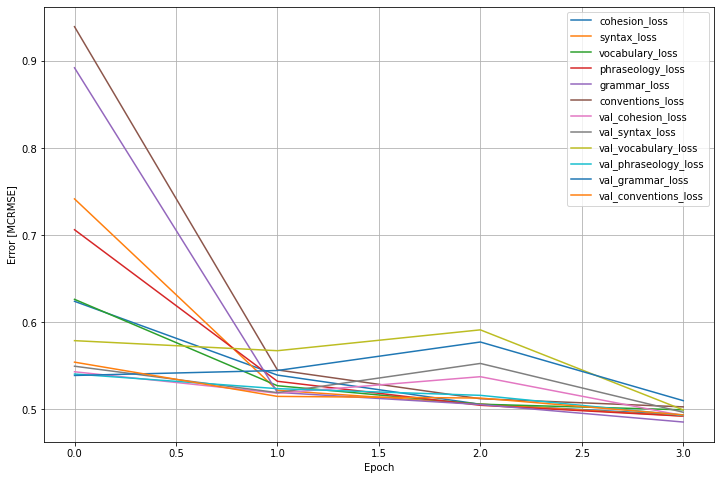

In [54]:
import matplotlib.pyplot as plt
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(8)
plt.plot(history.history['cohesion_loss'], label='cohesion_loss')
plt.plot(history.history['syntax_loss'], label='syntax_loss')
plt.plot(history.history['vocabulary_loss'], label='vocabulary_loss')
plt.plot(history.history['phraseology_loss'], label='phraseology_loss')
plt.plot(history.history['grammar_loss'], label='grammar_loss')
plt.plot(history.history['conventions_loss'], label='conventions_loss')
plt.plot(history.history['val_cohesion_loss'], label='val_cohesion_loss')
plt.plot(history.history['val_syntax_loss'], label='val_syntax_loss')
plt.plot(history.history['val_vocabulary_loss'], label='val_vocabulary_loss')
plt.plot(history.history['val_phraseology_loss'], label='val_phraseology_loss')
plt.plot(history.history['val_grammar_loss'], label='val_grammar_loss')
plt.plot(history.history['val_conventions_loss'], label='val_conventions_loss')
plt.xlabel('Epoch')
plt.ylabel('Error [MCRMSE]')
plt.legend(loc="upper right")
plt.grid(True)

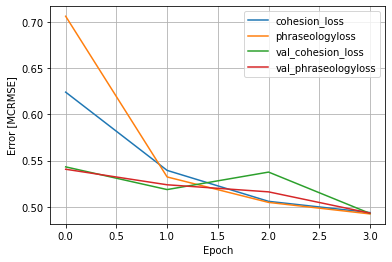

In [55]:
plt.plot(history.history['cohesion_loss'], label='cohesion_loss')
plt.plot(history.history['phraseology_loss'], label='phraseologyloss')
plt.plot(history.history['val_cohesion_loss'], label='val_cohesion_loss')
plt.plot(history.history['val_phraseology_loss'], label='val_phraseologyloss')
plt.xlabel('Epoch')
plt.ylabel('Error [MCRMSE]')
plt.legend()
plt.grid(True)

In [56]:
model.evaluate(validate_dataset)

157/157 [==============================] - 24s 149ms/step - loss: 2.9859 - cohesion_loss: 0.4928 - syntax_loss: 0.4967 - vocabulary_loss: 0.4995 - phraseology_loss: 0.4931 - grammar_loss: 0.5101 - conventions_loss: 0.4937 - cohesion_MCRMSE: 0.4932 - syntax_MCRMSE: 0.4968 - vocabulary_MCRMSE: 0.4991 - phraseology_MCRMSE: 0.4937 - grammar_MCRMSE: 0.5103 - conventions_MCRMSE: 0.4944


[2.985887289047241,
 0.49281513690948486,
 0.49672731757164,
 0.49945196509361267,
 0.4931369125843048,
 0.5100542306900024,
 0.49370118975639343,
 0.4931815564632416,
 0.49683597683906555,
 0.4990967810153961,
 0.4936664402484894,
 0.5103129744529724,
 0.49437111616134644]

In [57]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_input,train_data.drop('full_text', axis = 1)))
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
final = pd.DataFrame(train_df)
results = model.predict(train_dataset)
pred_cols = ['pred_cohesion', 'pred_syntax', 'pred_vocabulary', 'pred_phraseology', 'pred_grammar', 'pred_conventions']
for i in range(len(pred_cols)):
    col = pred_cols[i]
    final[col] = [float(x) for x in results[i]]
print(final.shape, final.head())
# validate.to_csv('m2_validation.csv', index=False)
# model.evaluate(validate_dataset)

(3128, 14)         text_id                                          full_text  cohesion  \
0  0016926B079C  I think that students would benefit from learn...       3.5   
1  0022683E9EA5  When a problem is a change you have to let it ...       2.5   
2  00299B378633  Dear, Principal\n\nIf u change the school poli...       3.0   
3  003885A45F42  The best time in life is when you become yours...       4.5   
4  0049B1DF5CCC  Small act of kindness can impact in other peop...       2.5   

   syntax  vocabulary  phraseology  grammar  conventions  pred_cohesion  \
0     3.5         3.0          3.0      4.0          3.0       3.086673   
1     2.5         3.0          2.0      2.0          2.5       2.990857   
2     3.5         3.0          3.0      3.0          2.5       2.770586   
3     4.5         4.5          4.5      4.0          5.0       3.757376   
4     3.0         3.0          3.0      2.5          2.5       2.388510   

   pred_syntax  pred_vocabulary  pred_phraseology  pred_g

In [58]:
final.to_csv('final.csv', index=False)

# 